2025-10-23 12:34:42.486645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 12:34:42.623925: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 12:34:44.141285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-23 12:34:44.248544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_g

Epoch 1/30


2025-10-23 12:34:44.648721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 12:34:44.649744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-23 12:34:44.652174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-23 12:34:44.653733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had 

   44/11187 [..............................] - ETA: 13s - loss: 1.8975 - accuracy: 0.3455    

2025-10-23 12:34:45.416570: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11187/11187 [==============================] - 13s 1ms/step - loss: 0.9561 - accuracy: 0.5419 - val_loss: 0.9230 - val_accuracy: 0.5550
Epoch 2/30
11187/11187 [==============================] - 14s 1ms/step - loss: 0.9250 - accuracy: 0.5552 - val_loss: 0.9124 - val_accuracy: 0.5623
Epoch 3/30
11187/11187 [==============================] - 13s 1ms/step - loss: 0.9201 - accuracy: 0.5580 - val_loss: 0.9096 - val_accuracy: 0.5696
Epoch 4/30
11187/11187 [==============================] - 13s 1ms/step - loss: 0.9178 - accuracy: 0.5597 - val_loss: 0.9067 - val_accuracy: 0.5700
Epoch 5/30
11187/11187 [==============================] - 15s 1ms/step - loss: 0.9160 - accuracy: 0.5617 - val_loss: 0.9047 - val_accuracy: 0.5666
Epoch 6/30
11187/11187 [==============================] - 20s 2ms/step - loss: 0.9142 - accuracy: 0.5634 - val_loss: 0.9028 - val_accuracy: 0.5738
Epoch 7/30
11187/11187 [==============================] - 20s 2ms/step - loss: 0.9135 - accuracy: 0.5641 - val_loss: 0.9017 - val

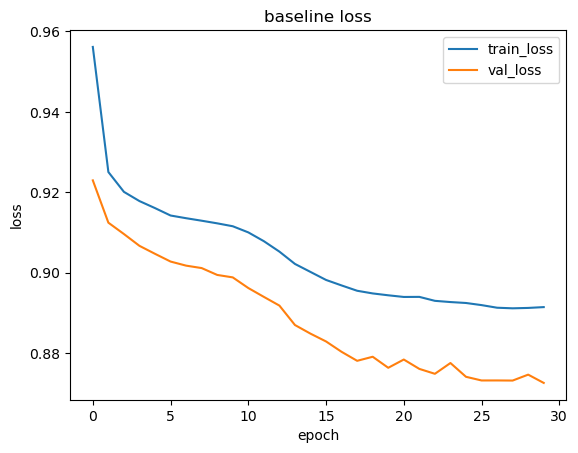

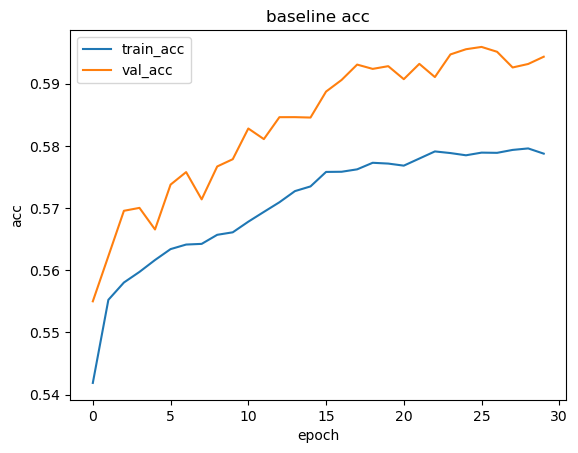

In [1]:
# minimal baseline mlp
# use gpu if available and enable memory growth
import tensorflow as tf
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# imports
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# load metadata
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)

# load arrays
X_train = np.load('../artifacts/X_train.npy')
X_val   = np.load('../artifacts/X_val.npy')
y_train = np.load('../artifacts/y_train.npy')
y_val   = np.load('../artifacts/y_val.npy')

# one hot labels
num_classes = len(meta['label_classes'])
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val, num_classes)

# simple scaling
# ranks are 1 to 13 suits are 0 to 3 scaling helps
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0) + 1e-8
X_train_s = (X_train - X_mean) / X_std
X_val_s   = (X_val   - X_mean) / X_std
np.save('../artifacts/X_mean.npy', X_mean)
np.save('../artifacts/X_std.npy', X_std)

# model
# input size is number of columns
inp = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(64, activation='relu')(inp)   # one hidden layer
x = keras.layers.Dropout(0.2)(x)                     # small dropout to reduce overfit
out = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inp, out)

# compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              jit_compile=False)  # leave false unless you want xla

# train
history = model.fit(
    X_train_s, y_train_oh,
    validation_data=(X_val_s, y_val_oh),
    epochs=30,
    batch_size=64,
    verbose=1
)

# plots
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('baseline loss')
plt.savefig('../artifacts/baseline_loss.png', dpi=150)

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.title('baseline acc')
plt.savefig('../artifacts/baseline_acc.png', dpi=150)

# save
model.save('../artifacts/baseline_model.keras')
with open('../artifacts/baseline_history.json','w') as f:
    json.dump(history.history, f)
